In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import random

In [3]:
theta = 3
n = 100

def get_sample(size, t):
    return [(1 - x)**(1 / (1-t)) for x in np.random.uniform(0,1,size)]

sample = get_sample(n, theta)


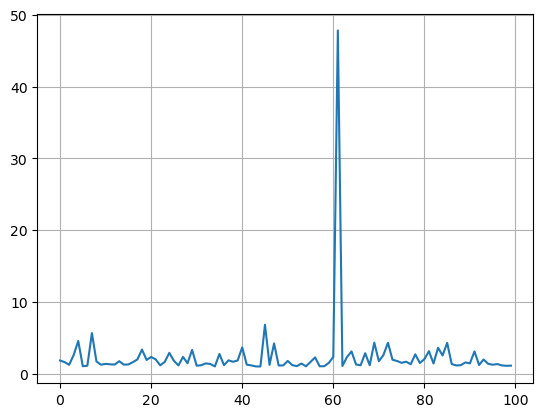

In [4]:
plt.plot(sample)
plt.grid()

In [5]:
theta_est = n/np.sum(np.log(sample))+1
print(f'estimation of theta by omp is {theta_est}')

estimation of theta by omp is 2.754790243943533


In [6]:
a = 2**(1/(theta_est-1)) - (1.96*np.log(2)*2**(1/(theta_est-1))) / (n**0.5*(theta_est-1))
b = 2**(1/(theta_est-1)) + (1.96*np.log(2)*2**(1/(theta_est-1))) / (n**0.5*(theta_est-1))
print(f' доверительный интервал для медианы: медиана между {np.round(a,5)} и {np.round(b,5)}')
print(f' real median is {np.round(stat.median(sample),5)}')
print(f' theta between {np.round(np.log(2)/np.log(b) +1, 5)} and {np.round(np.log(2)/np.log(a)+1,5)}')

 доверительный интервал для медианы: медиана между 1.36947 и 1.59931
 real median is 1.50062
 theta between 2.47612 and 3.20452


# асимптотический доверительный интервал омп

In [7]:
omp_b =  (1.96*(theta_est-1)/n**0.5)+theta_est
omp_a = - (1.96*(theta_est-1)/n**0.5)+theta_est
print(f'theta between {np.round(omp_a, 4)} and {np.round(omp_b, 4)} with 95% probability, real val is {theta}')

theta between 2.4109 and 3.0987 with 95% probability, real val is 3


# параметрический бутстрап


In [19]:
%%time
N = 50000

theta_est = n/np.sum(np.log(sample))+1
size = len(sample)

p_deltas = []
for i in range(N):
    cur_sample = get_sample(size, theta_est)
    cur_theta_est = n/np.sum(np.log(cur_sample))+1
    p_deltas.append(cur_theta_est - theta_est)
    
p_deltas.sort()
p_delta_025 = p_deltas[int(0.025*len(p_deltas))]
p_delta_975 = p_deltas[int(0.975*len(p_deltas))]

pbs_b = -1*(p_delta_025-theta_est)
pbs_a = -1*(p_delta_975-theta_est)

print(f'theta between {np.round(pbs_a, 4)} and {np.round(pbs_b, 4)} with 95% probability, real val is {theta}, iter = {N}')

theta between 2.3504 and 3.0592 with 95% probability, real val is 3, iter = 50000
CPU times: user 3.67 s, sys: 92 ms, total: 3.77 s
Wall time: 3.68 s


# непараметрический

In [20]:
theta_est = n/np.sum(np.log(sample))+1
N = 1000

size = len(sample)

sample_bs = sample.copy()
sample_bs = np.repeat(sample_bs, 20)

deltas = []
for i in range(N):
    random.shuffle(sample_bs)
    cur_theta_est = n/np.sum(np.log(sample_bs[:size]))+1
    deltas.append(cur_theta_est - theta_est)
    
deltas.sort()
delta_025 = deltas[int(0.025*len(deltas))]
delta_975 = deltas[int(0.975*len(deltas))]

bs_b = -1*(delta_025-theta_est)
bs_a = -1*(delta_975-theta_est)

print(f'theta between {np.round(bs_a, 4)} and {np.round(bs_b, 4)} with 95% probability, real val is {theta}')

theta between 2.3787 and 3.0396 with 95% probability, real val is 3


# Байес 

In [21]:
def func(x, n, prod):
    return np.exp(1-x)*(x-1)**n  / ((prod)**x)

def integrate(prod, c = None, prob = 0.025):
    integral = 0
    low = 1
    high = 10e2
    step = 10e-4
    
    idxs = np.arange(low, high, step)
    
    if c is not None:
         for i in range(len(idxs)-1):
            try:
                part = step * 0.5* (func(idxs[i], n, prod)+func(idxs[i+1], n, prod)) * c
                integral += part
            except:
                return idxs[i]

            if integral>=prob:
                return idxs[i]
        
    
    else:
        for i in range(len(idxs)-1):
            try:
                part = step * 0.5* (func(idxs[i], n, prod)+func(idxs[i+1], n, prod)) 
                integral += part
            except:
                return integral

        return integral

In [22]:
prod = np.product(sample)
integ = integrate(prod)

c = 1/integ

/var/folders/xq/7lrzzzm12635tbsgf5tdz5dh0000gn/T/ipykernel_9609/749957245.py:2: RuntimeWarning: overflow encountered in double_scalars
  return np.exp(1-x)*(x-1)**n  / ((prod)**x)


In [23]:
# найду границы для интеграла
by_a = integrate(prod, c, 0.025)
by_b = integrate(prod, c, 0.975)
print(f'theta between {np.round(by_a, 4)} and {np.round(by_b, 4)} with 95% probability, real val is {theta}')

theta between 2.418 and 3.097 with 95% probability, real val is 3


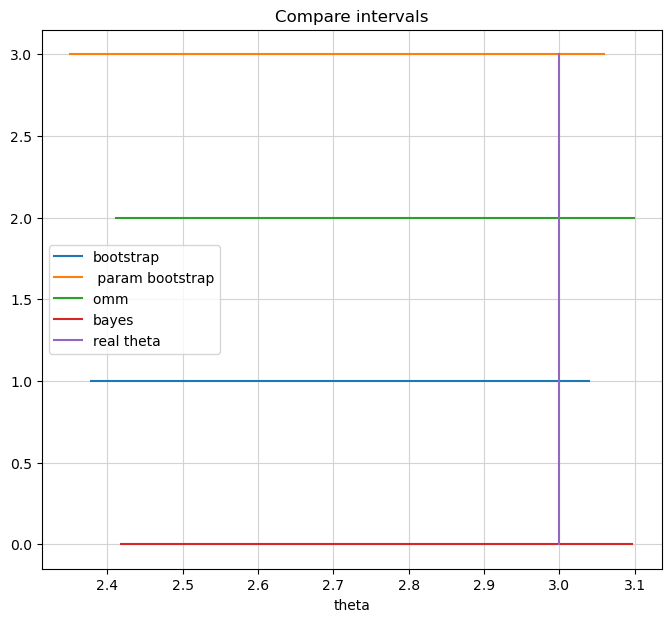

In [32]:
fig, ax = plt.subplots(figsize=(8,7))

ax.plot([bs_a, bs_b], [1,1], label = 'bootstrap')
ax.plot([pbs_a, pbs_b], [3,3], label = ' param bootstrap')
ax.plot([omp_a, omp_b], [2,2], label = 'omm ')
ax.plot([by_a, by_b], [0,0], label = 'bayes')
ax.plot([theta, theta], [0, 3], label = 'real theta')

ax.grid(color = 'lightgray')
ax.set_title('Compare intervals')    

ax.set_xlabel('theta')

ax.legend(loc = 'best')